In [1]:
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
import scipy.constants as const

# Ionization of atoms by intense laser pulses

In Laser Plasma Acceleration(LPA) ionization is used to convert regular matter (solid or gas) to a plasma. 
In Laser Wakefield Acceleration (LWFA), the driver laser pulse can be used to directly create a plasma in its wake. 
Special injection methods, so called ionization-injection methods, are used in LWFA to inject electrons into the accelerating plasma cavity. 
Thus, understanding ionization is essential for LPA. 

To model ionization processes, particle-in-cell codes are extended via various ionization models, like field- or collisional-ionization. 
Modeling ionization by laser pulses is treated by field-ionization methods lake Barrier Suppression Ionization (BSI) or tunneling ionization models like (ADK). 

## Laser model

In [2]:
z = np.linspace(-5e-6, 20.e-6, 2000) # position [m] 0µm-50µm
t = np.linspace(0.0, 100e-15, 1500) # time [s] 0fs-200fs

In [3]:
def laser(z, t, E=1.0e11, tau=10.0e-15, lambda_0=800.0e-9):
    return E * np.exp(-0.5 * ((z/const.c - t)/tau)**2) * np.sin((z - t * const.c) / lambda_0 * 2 * np.pi)

In [4]:
E_over_time = laser(z[:, np.newaxis], t[np.newaxis, :])

Plot space-time diagram of laser electric field strength. 

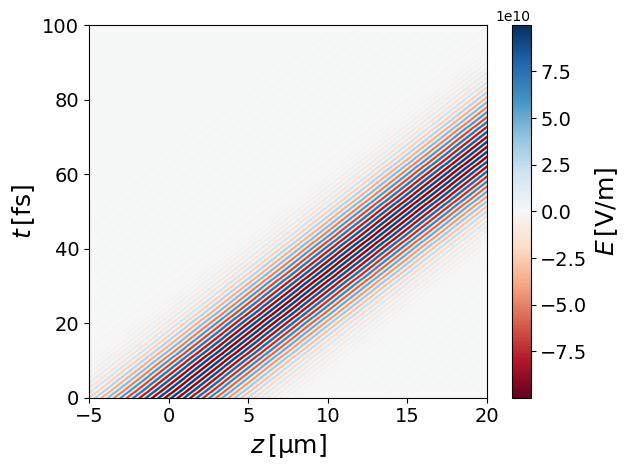

In [5]:
plt.pcolormesh(z/1e-6, t/1e-15, E_over_time.T, cmap=plt.cm.RdBu)

cb = plt.colorbar()

plt.xlabel(r"$z \, \mathrm{[\mu m]}$", fontsize=18)
plt.xticks(fontsize=14)

plt.ylabel(r"$t \, \mathrm{[fs]}$", fontsize=18)
plt.yticks(fontsize=14)

cb.set_label(r"$E \, \mathrm{[V/m]}$", fontsize=18)
for i in cb.ax.get_yticklabels():
    i.set_fontsize(14)
    
plt.tight_layout()
plt.show()

# BSI - Barrier Suppression Ionization

This is a classical picture of ionization where electrons, having a specific energy (determined by quantum mechanics), are trapped in the potential of the nuclei and are only freed if an external electric field is applied that bends the potential in such a way that one side of the potential barrier becomes smaller than the electron energy so that the electron of that specific energy can escape the atom's potential. 

The combined potential of the atom's nuclei and the external electric field can be described as:
$$ \Phi(x) = - \frac{Z \cdot q_e^2}{4 \pi \varepsilon_0 \left| x \right|} - q_e \cdot E_x^{\mathrm{ext}} \cdot x $$

A common algorithm that describes this is the so-called **Barrier Suppression Ionization (BSI)** that is e.g. described in [High Power Laser Matter Interaction by Bauer (2010)](https://doi.org/10.1007/978-3-540-46065-7).
There are two ways to describe if an electron is ionized from an atom. 
 - common BSI
 - BSI with Stark-shift
 
 In atomic physics, usually equations are stated in atomic units. 
 Here, we will do the same. 
 
 Assuming we have a Hydrogen atom. After ionization of is only electron, its charge state will be $Z=1$. The required ionization energy is $E_\mathrm{ion} = 13.6 \, \mathrm{eV}$. In [Atomic units (AU)](https://en.wikipedia.org/wiki/Atomic_units), this is an energy of: 
 

In [6]:
E_AU, _, _ = const.physical_constants["atomic unit of energy"] # [J] Hartree energy
E_ion_eV = 13.6 # eV
E_ion_SI = E_ion_eV * const.elementary_charge # [J]
E_ion_AU = E_ion_SI / E_AU # should be 0.5
print(f"E_ion = {E_ion_AU:.2f} A.U.") 

E_ion = 0.50 A.U.


The field strength required for classical (BSI) ionization in Atomic units is can be computed by ($F$ used for field, to avoid confusion with energy $E$):
$$ F_\mathrm{ion} = \frac{E_\mathrm{ion}^2}{4 \cdot Z}$$

In [7]:
Z = +1
F_AU, _, _ = const.physical_constants["atomic unit of electric field"] # [V/m]
F_ion_AU = E_ion_AU**2 / (4.0 * Z)
F_ion_SI = F_ion_AU * F_AU # [V/m]
print(f"elec. field for ionization {F_ion_SI:.2e} V/m")

elec. field for ionization 3.21e+10 V/m


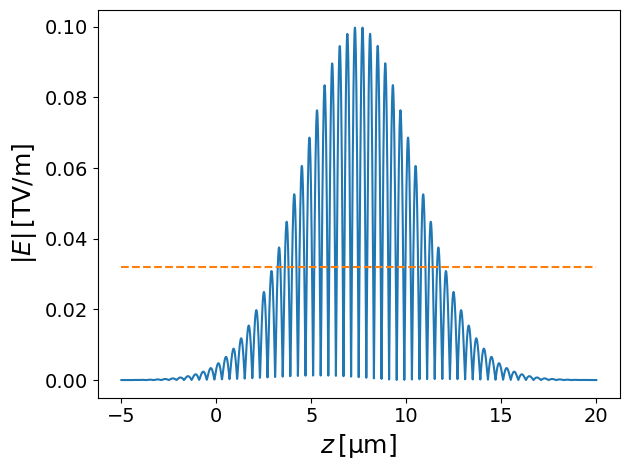

In [8]:
E_laser_snapshot = laser(z[:, np.newaxis], 25e-15)

plt.plot(z/1e-6, np.abs(E_laser_snapshot)/1e12)

plt.plot([-5, 20], np.array([F_ion_SI, F_ion_SI])/1e12, "--") # ionization threshold

plt.xlabel(r"$z \, \mathrm{[\mu m]}$", fontsize=18)
plt.xticks(fontsize=14)

plt.ylabel(r"$|E| \, \mathrm{[TV/m]}$", fontsize=18)
plt.yticks(fontsize=14)

plt.tight_layout()
plt.show()

# ADK - tunneling ionization rate

An alternative ionization model is the ADK model (Ammosov-Delone-Krainov).
It takes into account, that if an external electric field bends the  atom's potential, but not enough to reach the BSI level, there is a chance that the bound electron tunnels through the finite potential wall.
This probability is given as a rate (in atomic units):

$$ n_\mathrm{eff} = \frac{Z}{2 \cdot E_\mathrm{ion}}$$

$$ D = \left( \frac{4 \cdot \mathrm{e}^1 \cdot Z^3}{F \cdot n_\mathrm{eff}^4} \right)^{n_\mathrm{eff}} $$

$$ r = \frac{F \cdot D^2}{8 \cdot \pi \cdot Z} \cdot \frac{\mathrm{e}^{-2\cdot Z^3}}{3\cdot n_\mathrm{eff}^3 \cdot F} \cdot \underbrace{ \sqrt{ \frac{3 \cdot n_\mathrm{eff}^3 \cdot F}{\pi \cdot Z^3} } }_{\text{linear polarization}}$$

In [9]:
def ADKRate_linear(Z, E_ion_AU, F):
    """
    ADK ionization rate for linear polarization
    """
    n_eff = Z / np.sqrt(2.0 * E_ion_AU) # effective principal quantum number
    D = ((4.0 * np.exp(1.0) * Z**3.0) / (F * n_eff**4.0)) ** n_eff
    rate = (F * D**2.0) / (8.0 * np.pi * Z) * np.exp(-(2.0 * Z**3.0) / (3.0 * n_eff**3.0 * F))
    rate *= np.sqrt((3.0 * n_eff**3.0 * F) / (np.pi * Z**3.0)) # correction for linear polarization
    
    rate = np.nan_to_num(rate) # safety if F~0
    return rate
    

In [10]:
ADKRate_linear(1, E_ion_AU, F_ion_AU*0.99)

0.00038635041446072083